# Hyperparameter optimization

In this notebook, I approach the task of optimizing hyperparameters of a decoder and then use the decoder with those hyperparameters. I am using a parameters optimization package: ["hyperopt"](http://hyperopt.github.io/hyperopt/).
 - The first few sections (1-3) just import packages, load the files, and preprocess them
 - Section 4 apply [hyperopt](http://hyperopt.github.io/hyperopt/) on 5 decoders: DNN, RNN, GRU, LSTM, CNN, EEGNet
 - Section 5 display plots useful to analyze the output of the optimization

## 1. Import Packages

Below, we import both standard packages, and functions from the accompanying .py files

In [1]:
#Adding working directory to python path
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # or any {'0', '1', '2'}
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
#Import standard packages
import numpy as np
np.random.seed(27) # Seed is important for having the same test set for performance comparison
from scipy import io, stats
import pickle as pkl
import json
from utils.functions import *
from math import ceil

#Import tensorflow
import tensorflow as tf
# tf.get_logger().setLevel('ERROR')
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

#Import graphics
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
import seaborn as sns
from PIL import Image
from IPython.display import HTML

#Import function to laod and process dataset
from utils.data_processing import * 
from sklearn.preprocessing import LabelEncoder

#Import metrics
from sklearn.metrics import accuracy_score, r2_score, log_loss

#Import decoder functions
from utils.decoders import *

#Import hyperparameter optimization packages
from hyperopt import fmin, hp, Trials, tpe, STATUS_OK, space_eval

In [3]:
#Turn off deprecation warnings

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

## 2. Inputs

In [4]:
FILE = 'MRec40'  # MRec40, ZRec50 or ZRec50_Mini
EPOCH = 'go'
PLOTS_FOLDER = '../plots/hyperopt'
SETS_FOLDER = '../data/offline'
FULL_DATASET_PATH = f'../data/Objects Task DL Project/{FILE}.neo.mat' 

K = 5 # N of repetitions
N_EVAL = 200 # N of tested configurations

TRAIN_SPLIT = 0.7
VAL_SPLIT = 0.15

selector = ObjectSelector()
new_classes = selector.get_non_special(group_labels=False) # Which labels to use from the original 50s

## 3. Load Data
Neural data collected as numpy array of windows "number of neurons" x "number of time bins", where each entry is the firing rate of a given neuron in a given time bin. To each window is associated the object grasped in that trial.

In [5]:
# Check if proper dataset was previously generated and stored
try:
    x_train = np.load(f'{SETS_FOLDER}/{K}_x_train.npy')
    x_val = np.load(f'{SETS_FOLDER}/{K}_x_val.npy')
    x_test = np.load(f'{SETS_FOLDER}/{K}_x_test.npy')
    y_train = np.load(f'{SETS_FOLDER}/{K}_y_train.npy')
    y_val = np.load(f'{SETS_FOLDER}/{K}_y_val.npy')
    y_test = np.load(f'{SETS_FOLDER}/{K}_y_test.npy')
    
# If not proceed generating them
except:
    # LOAD FULL DATASET
    measurements, objects, _, _ = load_dataset(FULL_DATASET_PATH, EPOCH)
    
    # PREPROCESSING
    label_encoder = LabelEncoder()
    X, Y = preprocess_dataset(measurements, objects, labelled_classes=new_classes, one_hot_encoder=label_encoder)

    print('X shape and Y shape')
    print(X.shape, Y.shape, '\n')
    unique_y, n_repetition = np.unique(label_encoder.inverse_transform(Y.argmax(axis=1)), return_counts=True, axis=0)
    print('object ID and repetition in the dataset:' )
    for elem in zip(unique_y, n_repetition):
        print(elem, end='    ')
    print('\n')
    
    # SPLIT INTO TRAINING / VALIDATION / TESTING SETS
    (x_train, y_train), (x_val, y_val), (x_test, y_test) = split_sets(X, Y, tr_split=TRAIN_SPLIT, val_split=VAL_SPLIT, repetitions=K, normalize_classes=False)
    
    # STORE
    np.save(f'{SETS_FOLDER}/{K}_x_train', x_train)
    np.save(f'{SETS_FOLDER}/{K}_x_val', x_val)
    np.save(f'{SETS_FOLDER}/{K}_x_test', x_test)
    np.save(f'{SETS_FOLDER}/{K}_y_train', y_train)
    np.save(f'{SETS_FOLDER}/{K}_y_val', y_val)
    np.save(f'{SETS_FOLDER}/{K}_y_test', y_test)

(_, channels, window) = x_train[0].shape
outputs = y_train[0].shape[1]
print(f'number of repetitions K: {K}')
print(f'train: {K}*{np.array(x_train).shape[1:]} -- validation: {K}*{np.array(x_val).shape[1:]} -- test: {np.array(x_test).shape}')


number of repetitions K: 5
train: 5*(302, 552, 15) -- validation: 5*(65, 552, 15) -- test: (65, 552, 15)


## 4. Optimize Hyperparameters of decoders using "Hyperopt"
The general idea is that we will try to find the decoder hyperparameters that produce the highest accuracy score on the validation set. Explaining images and animation taken from [https://www.kaggle.com/fanvacoolt/tutorial-on-hyperopt/](https://www.kaggle.com/fanvacoolt/tutorial-on-hyperopt/)

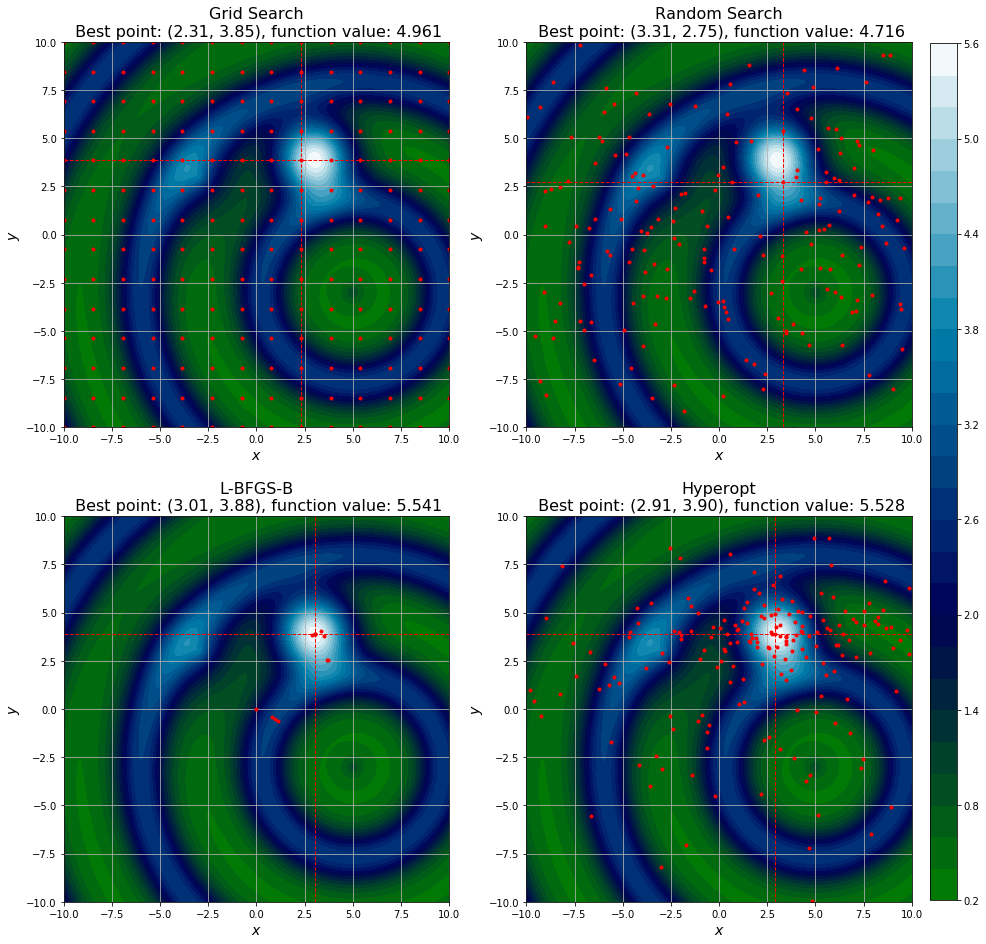

In [6]:
pil_im = Image.open('../data/resources/hyperopt.png', 'r')
display(pil_im)
animation = pkl.load(open('../data/resources/ani1.pkl', "rb"))
animation

### 4A. Dense Neural Net (DNN)
The hyperparameters we are trying to optimize are:
 - "num_neurons (the number of hidden units in the first layer)
 - "frac_dropout" (the proportion of units that are dropped out"
 - "n_epochs" (the number of epochs used for fitting)
 - "batch_size" (the number of inputs to fit the model on in every iteration)


#### Define a function that returns the accuracy of the validation set as a function of the hyperparameter (degree)
Hyperopt minimizes the loss value, so I'm returning the average log loss on the validation set

In [7]:
def dnn_evaluate(params):
    #Put parameters in proper format
    num_neurons=int(params['num_neurons'])
    frac_dropout=float(params['frac_dropout'])
    n_epochs=int(params['n_epochs'])
    batch_size=int(params['batch_size'])
    
    model_dnn=DenseNNClassification(window, channels, outputs, units=num_neurons,dropout=frac_dropout) #Define model
    test_accuracy = []
    test_loss = []
    loss = []
    for k in range(K):
        model_dnn.reset_weights()
        try:
            history = model_dnn.fit(x_train[k],y_train[k],batch_size=batch_size, num_epochs=n_epochs) #Fit model
            loss.append(history.history['loss'][-1])
            predictions=model_dnn.predict(x_val[k]) #Get validation set predictions
            test_accuracy.append(accuracy_score(y_val[k].argmax(axis=1), predictions.argmax(axis=1)))
            test_loss.append(log_loss(y_val[k], predictions))
        except:
            print("Unexpected error:", sys.exc_info())
            print(params)
            print(model_dnn.model.summary())
            raise    
    
    loss = np.array(loss)
    test_loss = np.array(test_loss)
    test_accuracy = np.array(test_accuracy)
    return {
        'loss': test_loss.mean(),
        'train_loss': loss.mean(), 
        'status': STATUS_OK,
        'test_accuracy': test_accuracy.mean()
    }

#### Set range of hyperparameters, and run optimization

In [8]:
#The range of values I'll look at for the parameter
#"hp.quniform" will allow us to look at integer (rather than continuously spaced) values.
#So for "num_neurons", we are looking at values between 50 and 700 by 10 (50,60,70,...700)
#"hp.uniform" looks at continuously spaced values
dnn_space = {
    'num_neurons': hp.quniform('num_neurons', 32,640,32),
    'frac_dropout': hp.quniform('frac_dropout', 0., 0.5, 0.05),
    'n_epochs': hp.quniform('n_epochs', 5,50,5),
    'batch_size': hp.quniform('batch_size', 2, 26, 2)
}
    
pkl.dump(dnn_space, open('../results/hyperopt/dnn.space', "wb"))

#object that holds iteration results
dnn_trials = Trials()

In [9]:
#Perform optimization; it is split in iterations to create checkpoints
for n in range(20, N_EVAL+1, 20):
    try:
        dnn_trials = pkl.load(open('../results/hyperopt/dnn.trials', "rb"))
    except:
        pass
    dnn_hyperoptBest = fmin(dnn_evaluate, dnn_space, algo=tpe.suggest, max_evals=n, trials=dnn_trials)
    pkl.dump(dnn_trials, open('../results/hyperopt/dnn.trials', "wb"))

100%|███████████████████████████████████████████████| 200/200 [01:20<00:00,  4.03s/trial, best loss: 2.203349035050577]


#### Get best hyperparameters and save them in the configuration file

In [10]:
print("Accuracy_validation: ",dnn_trials.best_trial['result']['test_accuracy'], ', obtained with configuration: ')
print(dnn_hyperoptBest)

with open('../utils/hyperparameters.json', 'r') as outfile:
    try:
        config = json.load(outfile)
    except:
        config = {}
config['dnn'] = dnn_hyperoptBest
with open('../utils/hyperparameters.json', 'w') as outfile:
    json.dump(config, outfile, indent=4)

Accuracy_validation:  0.28 , obtained with configuration: 
{'batch_size': 18.0, 'frac_dropout': 0.25, 'n_epochs': 15.0, 'num_units': 608.0}


### 4B. Simple Recurrent Neural Network (RNN)
The hyperparameters we are trying to optimize are:
 - "num_units" (the number of hidden units in the recurrent layer)
 - "frac_dropout" (the proportion of units that are dropped out"
 - "n_epochs" (the number of epochs used for fitting)
 - "batch_size" (the number of inputs to fit the model on in every iteration)

#### Define a function that returns the accuracy of the validation set as a function of the hyperparameter (degree)
Hyperopt minimizes the parameter, so we will return -accuracy (in order to maximize it)

In [11]:
def rnn_evaluate(params):
    #Put parameters in proper format
    num_units=int(params['num_units'])
    frac_dropout=float(params['frac_dropout'])
    n_epochs=int(params['n_epochs'])
    batch_size=int(params['batch_size'])

    model_rnn=SimpleRNNClassification(window, channels, outputs, units=num_units,dropout=frac_dropout) #Define model
    test_accuracy = []
    test_loss = []
    loss = []
    for k in range(K):
        model_rnn.reset_weights()
        try:
            history = model_rnn.fit(x_train[k],y_train[k],batch_size=batch_size, num_epochs=n_epochs) #Fit model
            loss.append(history.history['loss'][-1])
            predictions=model_rnn.predict(x_val[k]) #Get validation set predictions
            test_accuracy.append(accuracy_score(y_val[k].argmax(axis=1), predictions.argmax(axis=1)))
            test_loss.append(log_loss(y_val[k], predictions))
        except:
            print("Unexpected error:", sys.exc_info())
            print(params)
            print(model_ensemble.model.summary())
            raise
            
    loss = np.array(loss)
    test_loss = np.array(test_loss)
    test_accuracy = np.array(test_accuracy)
    return {
        'loss': test_loss.mean(),
        'train_loss': loss.mean(), 
        'status': STATUS_OK,
        'test_accuracy': test_accuracy.mean()
    }

#### Set range of hyperparameters, and run optimization

In [12]:
#The range of values I'll look at for the parameter
#"hp.quniform" will allow us to look at integer (rather than continuously spaced) values.
#So for "num_units", we are looking at values between 50 and 700 by 10 (50,60,70,...700)
#"hp.uniform" looks at continuously spaced values
rnn_space = {
    'num_units': hp.quniform('num_units', 16,256,16),
    'frac_dropout': hp.quniform('frac_dropout', 0., 0.5, 0.05),
    'n_epochs': hp.quniform('n_epochs', 5,50,5),
    'batch_size': hp.quniform('batch_size', 2, 26, 2)
}

pkl.dump(rnn_space, open('../results/hyperopt/rnn.space', "wb"))

#object that holds iteration results
rnn_trials = Trials()

In [13]:
#Perform optimization; it is split in iterations to create checkpoints
for n in range(20, N_EVAL+1, 20):
    try:
        rnn_trials = pkl.load(open('../results/hyperopt/rnn.trials', "rb"))
    except:
        pass
    rnn_hyperoptBest = fmin(rnn_evaluate, rnn_space, algo=tpe.suggest, max_evals=n, trials=rnn_trials)
    pkl.dump(rnn_trials, open('../results/hyperopt/rnn.trials', "wb"))

100%|██████████████████████████████████████████████| 200/200 [14:47<00:00, 44.37s/trial, best loss: 1.8807731630939704]


#### Get best hyperparameters and save them in the configuration file

In [14]:
print("Accuracy_validation: ",rnn_trials.best_trial['result']['test_accuracy'], ', obtained with configuration: ')
print(rnn_hyperoptBest)

with open('../utils/hyperparameters.json', 'r') as outfile:
    try:
        config = json.load(outfile)
    except:
        config = {}
config['rnn'] = rnn_hyperoptBest
with open('../utils/hyperparameters.json', 'w') as outfile:
    json.dump(config, outfile, indent=4)

Accuracy_validation:  0.39384615384615385 , obtained with configuration: 
{'batch_size': 8.0, 'frac_dropout': 0.5, 'n_epochs': 30.0, 'num_units': 256.0}


### 4C. Gated Recurrent Unit (GRU)
The hyperparameters we are trying to optimize are:
 - "num_units" (the number of hidden units in the recurrent layer)
 - "frac_dropout" (the proportion of units that are dropped out"
 - "n_epochs" (the number of epochs used for fitting)
 - "batch_size" (the number of inputs to fit the model on in every iteration)

#### Define a function that returns the accuracy of the validation set as a function of the hyperparameter (degree)
Hyperopt minimizes the parameter, so we will return -accuracy (in order to maximize it)

In [15]:
def gru_evaluate(params):
    #Put parameters in proper format
    num_units=int(params['num_units'])
    frac_dropout=float(params['frac_dropout'])
    n_epochs=int(params['n_epochs'])
    batch_size=int(params['batch_size'])

    model_gru=GRUClassification(window, channels, outputs, units=num_units, dropout=frac_dropout) #Define model
    test_accuracy = []
    test_loss = []
    loss = []
    for k in range(K):
        model_gru.reset_weights()
        try:
            history = model_gru.fit(x_train[k],y_train[k],batch_size=batch_size, num_epochs=n_epochs) #Fit model
            loss.append(history.history['loss'][-1])
            predictions=model_gru.predict(x_val[k]) #Get validation set predictions
            test_accuracy.append(accuracy_score(y_val[k].argmax(axis=1), predictions.argmax(axis=1)))
            test_loss.append(log_loss(y_val[k], predictions))
        except:
            print("Unexpected error:", sys.exc_info())
            print(params)
            print(model_gru.model.summary())
            raise
    
    loss = np.array(loss)
    test_loss = np.array(test_loss)
    test_accuracy = np.array(test_accuracy)
    return {
        'loss': test_loss.mean(),
        'train_loss': loss.mean(), 
        'status': STATUS_OK,
        'test_accuracy': test_accuracy.mean()
    }

#### Set range of hyperparameters, and run optimization

In [16]:
#The range of values I'll look at for the parameter
#"hp.quniform" will allow us to look at integer (rather than continuously spaced) values.
#So for "num_units", we are looking at values between 50 and 700 by 10 (50,60,70,...700)
#"hp.uniform" looks at continuously spaced values
gru_space = {
    'num_units': hp.quniform('num_units', 16,256,16),
    'frac_dropout': hp.quniform('frac_dropout', 0., 0.5, 0.05),
    'n_epochs': hp.quniform('n_epochs', 5,50,5),
    'batch_size': hp.quniform('batch_size', 2, 26, 2)
}
    
pkl.dump(gru_space, open('../results/hyperopt/gru.space', "wb"))

#object that holds iteration results
gru_trials = Trials()

In [17]:
#Perform optimization; it is split in iterations to create checkpoints
for n in range(20, N_EVAL+1, 20):
    try:
        gru_trials = pkl.load(open('../results/hyperopt/gru.trials', "rb"))
    except:
        pass
    gru_hyperoptBest = fmin(gru_evaluate, gru_space, algo=tpe.suggest, max_evals=n, trials=gru_trials)
    pkl.dump(gru_trials, open('../results/hyperopt/gru.trials', "wb"))

100%|██████████████████████████████████████████████| 200/200 [02:40<00:00,  8.00s/trial, best loss: 1.5536946248205807]


#### Get best hyperparameters and save them in the configuration file

In [18]:
print("Accuracy_validation: ",gru_trials.best_trial['result']['test_accuracy'], ', obtained with configuration: ')
print(gru_hyperoptBest)

with open('../utils/hyperparameters.json', 'r') as outfile:
    try:
        config = json.load(outfile)
    except:
        config = {}
config['gru'] = gru_hyperoptBest
with open('../utils/hyperparameters.json', 'w') as outfile:
    json.dump(config, outfile, indent=4)

Accuracy_validation:  0.44000000000000006 , obtained with configuration: 
{'batch_size': 24.0, 'frac_dropout': 0.05, 'n_epochs': 25.0, 'num_units': 240.0}


### 4D. Long Short-Term Memory (LSTM)
The hyperparameters we are trying to optimize are:
 - "num_units" (the number of hidden units in the recurrent layer)
 - "frac_dropout" (the proportion of units that are dropped out"
 - "n_epochs" (the number of epochs used for fitting)
 - "batch_size" (the number of inputs to fit the model on in every iteration)

#### Define a function that returns the accuracy of the validation set as a function of the hyperparameter (degree)
Hyperopt minimizes the parameter, so we will return -accuracy (in order to maximize it)

In [19]:
def lstm_evaluate(params):
    #Put parameters in proper format
    num_units=int(params['num_units'])
    frac_dropout=float(params['frac_dropout'])
    n_epochs=int(params['n_epochs'])
    batch_size=int(params['batch_size'])

    model_lstm=LSTMClassification(window, channels, outputs, units=num_units,dropout=frac_dropout) #Define model
    test_accuracy = []
    test_loss = []
    loss = []
    for k in range(K):
        model_lstm.reset_weights()
        try:
            history = model_lstm.fit(x_train[k],y_train[k],batch_size=batch_size, num_epochs=n_epochs) #Fit model
            loss.append(history.history['loss'][-1])
            predictions=model_lstm.predict(x_val[k]) #Get validation set predictions
            test_accuracy.append(accuracy_score(y_val[k].argmax(axis=1), predictions.argmax(axis=1)))
            test_loss.append(log_loss(y_val[k], predictions))
        except:
            print("Unexpected error:", sys.exc_info())
            print(params)
            print(model_lstm.model.summary())
            raise
    
    loss = np.array(loss)
    test_loss = np.array(test_loss)
    test_accuracy = np.array(test_accuracy)
    return {
        'loss': test_loss.mean(),
        'train_loss': loss.mean(), 
        'status': STATUS_OK,
        'test_accuracy': test_accuracy.mean()
    }

#### Set range of hyperparameters, and run optimization

In [20]:
#The range of values I'll look at for the parameter
#"hp.quniform" will allow us to look at integer (rather than continuously spaced) values.
#So for "num_units", we are looking at values between 50 and 700 by 10 (50,60,70,...700)
#"hp.uniform" looks at continuously spaced values
lstm_space = {
    'num_units': hp.quniform('num_units', 16,256,16),
    'frac_dropout': hp.quniform('frac_dropout', 0., 0.5, 0.05),
    'n_epochs': hp.quniform('n_epochs', 5,50,5),
    'batch_size': hp.quniform('batch_size', 2, 26, 2)
}
    
pkl.dump(lstm_space, open('../results/hyperopt/lstm.space', "wb"))

#object that holds iteration results
lstm_trials = Trials()

In [21]:
#Perform optimization; it is split in iterations to create checkpoints
for n in range(20, N_EVAL+1, 20):
    try:
        lstm_trials = pkl.load(open('../results/hyperopt/lstm.trials', "rb"))
    except:
        pass
    lstm_hyperoptBest = fmin(lstm_evaluate, gru_space, algo=tpe.suggest, max_evals=n, trials=lstm_trials)
    pkl.dump(lstm_trials, open('../results/hyperopt/lstm.trials', "wb"))

100%|██████████████████████████████████████████████| 200/200 [02:55<00:00,  8.80s/trial, best loss: 1.4366333422179405]


#### Get best hyperparameters and save them in the configuration file

In [22]:
print("Accuracy_validation: ",lstm_trials.best_trial['result']['test_accuracy'], ', obtained with configuration: ')
print(lstm_hyperoptBest)

with open('../utils/hyperparameters.json', 'r') as outfile:
    try:
        config = json.load(outfile)
    except:
        config = {}
config['lstm'] = lstm_hyperoptBest
with open('../utils/hyperparameters.json', 'w') as outfile:
    json.dump(config, outfile, indent=4)

Accuracy_validation:  0.44000000000000006 , obtained with configuration: 
{'batch_size': 20.0, 'frac_dropout': 0.05, 'n_epochs': 25.0, 'num_units': 256.0}


### 4E. Convolutional Neural Network (CNN)
The hyperparameters we are trying to optimize are:
 - "num_filters" (the number of hidden units in the convolutional layer)
 - "kernel_size" (the dimension of each filter)
 - "frac_dropout" (the proportion of units that are dropped out"
 - "n_epochs" (the number of epochs used for fitting)
 - "batch_size" (the number of inputs to fit the model on in every iteration)

#### Define a function that returns the accuracy of the validation set as a function of the hyperparameter (degree)
Hyperopt minimizes the parameter, so we will return -accuracy (in order to maximize it)

In [6]:
def cnn_evaluate(params):
    #Put parameters in proper format
    num_filters=int(params['num_filters'])
    kernel_size_1=int(params['kernel_size_1'])
    kernel_size_2=int(params['kernel_size_2'])
    frac_dropout=float(params['frac_dropout'])
    pool_size=int(params['pool_size'])
    n_epochs=int(params['n_epochs'])
    batch_size=int(params['batch_size'])
    
    model_cnn=CNNClassification(window, channels, outputs, filters=num_filters,size=(kernel_size_1, kernel_size_2),dropout=frac_dropout,pool_size=pool_size) #Define model
    test_accuracy = []
    test_loss = []
    loss = []
    for k in range(K):
        model_cnn.reset_weights()
        try:
            history = model_cnn.fit(x_train[k],y_train[k],batch_size=batch_size, num_epochs=n_epochs) #Fit model
            loss.append(history.history['loss'][-1])
            predictions=model_cnn.predict(x_val[k]) #Get validation set predictions
            test_accuracy.append(accuracy_score(y_val[k].argmax(axis=1), predictions.argmax(axis=1)))
            test_loss.append(log_loss(y_val[k], predictions))
        except:
            print("Unexpected error:", sys.exc_info())
            print(params)
            print(model_cnn.model.summary())
            raise
    
    loss = np.array(loss)
    test_loss = np.array(test_loss)
    test_accuracy = np.array(test_accuracy)
    return {
        'loss': test_loss.mean(),
        'train_loss': loss.mean(), 
        'status': STATUS_OK,
        'test_accuracy': test_accuracy.mean()
    }

#### Set range of hyperparameters, and run optimization

In [11]:
#The range of values I'll look at for the parameter
#"hp.quniform" will allow us to look at integer (rather than continuously spaced) values.
#So for "num_units", we are looking at values between 50 and 700 by 10 (50,60,70,...700)
#"hp.uniform" looks at continuously spaced values
cnn_space = {
    'num_filters': hp.quniform('num_filters', 32, 256, 32),
    'kernel_size_1': hp.quniform('kernel_size_1', 50, channels-50, 50),
    'kernel_size_2': hp.quniform('kernel_size_2', 3, window-3, 3),
    'frac_dropout': hp.quniform('frac_dropout', 0., 0.5, 0.05),
    'pool_size': hp.choice('pool_size', [2, 0]),
    'n_epochs': hp.quniform('n_epochs', 5,50,5),
    'batch_size': hp.quniform('batch_size', 2, 26, 2)
}

pkl.dump(cnn_space, open('../results/hyperopt/cnn.space', "wb"))

#object that holds iteration results
cnn_trials = Trials()

In [12]:
#Perform optimization; it is split in iterations to create checkpoints
for n in range(20, N_EVAL+1, 20):
    try:
        cnn_trials = pkl.load(open('../results/hyperopt/cnn.trials', "rb"))
    except:
        pass
    cnn_hyperoptBest = fmin(cnn_evaluate, cnn_space, algo=tpe.suggest, max_evals=n, trials=cnn_trials)
    pkl.dump(cnn_trials, open('../results/hyperopt/cnn.trials', "wb"))

100%|██████████████████████████████████████████████| 200/200 [10:20<00:00, 31.02s/trial, best loss: 1.7966646484905282]


#### Get best hyperparameters and save them in the configuration file

In [13]:
print("Accuracy_validation: ",cnn_trials.best_trial['result']['test_accuracy'], ', obtained with configuration: ')
cnn_hyperoptBest['pool_size'] = [2., 0.][cnn_hyperoptBest['pool_size']]
print(cnn_hyperoptBest)

with open('../utils/hyperparameters.json', 'r') as outfile:
    try:
        config = json.load(outfile)
    except:
        config = {}
config['cnn'] = cnn_hyperoptBest
with open('../utils/hyperparameters.json', 'w') as outfile:
    json.dump(config, outfile, indent=4)

Accuracy_validation:  0.31384615384615383 , obtained with configuration: 
{'batch_size': 20.0, 'frac_dropout': 0.4, 'kernel_size_1': 500.0, 'kernel_size_2': 6.0, 'n_epochs': 25.0, 'num_filters': 192.0, 'pool_size': 2.0}


### 4F. Ensemble (CNN + LSTM)
The hyperparameters we are trying to optimize are:
 - "n_filters" (the number of hidden units in the convolutional layer)
 - "size" (of the monodimensional filters)
 - "activation" (non linear function to activate the convolutional layer - "relu" or "elu")
 - "frac_dropout_1" (the proportion of regularization applied after the convolution)
 - "recurrent_layer" (the typology of recurrent layer to apply - "LSTM" or "GRU")
 - "n_units" (the number of hidden units in the recurrent layer)
 - "frac_dropout_2" (the proportion of regularization applied after the recursion)
 - "n_neurons" (the number of hidden units in the dense layer)
 - "n_epochs" (the number of training epochs)
 - "batch_size" (the number of input examples to feed the network during every iteration)


#### Define a function that returns the accuracy of the validation set as a function of the hyperparameter (degree)
Hyperopt minimizes the parameter, so we will return -accuracy (in order to maximize it)

In [27]:
def ensemble_evaluate(params):
    #Put parameters in proper format
    n_filters=int(params['n_filters'])
    size=int(params['size'])
    activation = params['activation'] # relu or elu
    frac_dropout_1=float(params['frac_dropout_1'])
    pooling_layer=params['pooling_layer'] # MaxPooling or AvgPooling
    recurrent_layer=params['recurrent_layer'] # GRU or LSTM
    n_units=int(params['n_units'])
    frac_dropout_2=float(params['frac_dropout_2'])
    n_neurons=int(params['n_neurons'])
    n_epochs=int(params['n_epochs'])
    batch_size=int(params['batch_size'])
    
    model_ensemble=Ensemble(channels, outputs, filters=n_filters, filters_size=size, activation=activation, dropout=frac_dropout_1, 
                            pooling_layer=pooling_layer, recurrent_layer=recurrent_layer, recurrent_dropout=frac_dropout_2, units=n_units, 
                            neurons=n_neurons) #Define model
    test_accuracy = []
    test_loss = []
    loss = []
    for k in range(K):
        model_ensemble.reset_weights()
        try:
            history = model_ensemble.fit(x_train[k],y_train[k],batch_size=batch_size, num_epochs=n_epochs) #Fit model
            loss.append(history.history['loss'][-1])
            predictions=model_ensemble.predict(x_val[k]) #Get validation set predictions
            test_accuracy.append(accuracy_score(y_val[k].argmax(axis=1), predictions.argmax(axis=1)))
            test_loss.append(log_loss(y_val[k], predictions))
        except:
            print("Unexpected error:", sys.exc_info())
            print(params)
            print(model_ensemble.model.summary())
            raise
            
    loss = np.array(loss)
    test_loss = np.array(test_loss)
    test_accuracy = np.array(test_accuracy)
    return {
        'loss': test_loss.mean(),
        'train_loss': loss.mean(), 
        'status': STATUS_OK,
        'test_accuracy': test_accuracy.mean()
    }

#### Set range of hyperparameters, and run optimization

In [28]:
#The range of values I'll look at for the parameter
#"hp.quniform" will allow us to look at integer (rather than continuously spaced) values.
#So for "num_units", we are looking at values between 50 and 700 by 10 (50,60,70,...700)
#"hp.uniform" looks at continuously spaced values
ensemble_space = {
    'n_filters': hp.quniform('n_filters', 4, 64, 4),
    'size': hp.quniform('size', 16, ceil(channels/2), 16),
    'activation': hp.choice('activation', ['relu', 'elu']),
    'frac_dropout_1': hp.quniform('frac_dropout_1', 0., 0.5, 0.05),
    'pooling_layer': hp.choice('pooling_layer', ['max', 'avg']),
    'recurrent_layer': hp.choice('recurrent_layer', ['gru', 'lstm']),
    'n_units': hp.quniform('n_units', 16, 256, 16),
    'frac_dropout_2': hp.quniform('frac_dropout_2', 0., 0.5, 0.05),
    'n_neurons': hp.quniform('n_neurons', 32, 512, 32),
    'n_epochs': hp.quniform('n_epochs', 5, 50, 5),
    'batch_size': hp.quniform('batch_size', 2, 26, 2)
}
    
pkl.dump(ensemble_space, open('../results/hyperopt/ensemble.space', "wb"))

#object that holds iteration results
ensemble_trials = Trials()

In [29]:
#Perform optimization; it is split in iterations to create checkpoints
for n in range(20, N_EVAL*2+1, 20):
    try:
        ensemble_trials = pkl.load(open('../results/hyperopt/ensemble.trials', "rb"))
    except:
        pass
    ensemble_hyperoptBest = fmin(ensemble_evaluate, ensemble_space, algo=tpe.suggest, max_evals=n, trials=ensemble_trials)
    pkl.dump(ensemble_trials, open('../results/hyperopt/ensemble.trials', "wb"))

100%|██████████████████████████████████████████████| 400/400 [07:35<00:00, 22.75s/trial, best loss: 1.0389452229913037]


#### Get best hyperparameters and save them in the configuration file

In [30]:
print("Accuracy_validation: ",ensemble_trials.best_trial['result']['test_accuracy'], ', obtained with configuration: ')
ensemble_hyperoptBest['pooling_layer'] = ['max', 'avg'][ensemble_hyperoptBest['pooling_layer']]
ensemble_hyperoptBest['recurrent_layer'] = ['gru', 'lstm'][ensemble_hyperoptBest['recurrent_layer']]
ensemble_hyperoptBest['activation'] = ['relu', 'elu'][ensemble_hyperoptBest['activation']]
print(ensemble_hyperoptBest)

with open('../utils/hyperparameters.json', 'r') as outfile:
    try:
        config = json.load(outfile)
    except:
        config = {}
config['ensemble'] = ensemble_hyperoptBest
with open('../utils/hyperparameters.json', 'w') as outfile:
    json.dump(config, outfile, indent=4)

Accuracy_validation:  0.5815384615384616 , obtained with configuration: 
{'activation': 'elu', 'batch_size': 20.0, 'frac_dropout_1': 0.25, 'frac_dropout_2': 0.4, 'n_epochs': 50.0, 'n_filters': 60.0, 'n_neurons': 448.0, 'n_units': 80.0, 'pooling_layer': 'max', 'recurrent_layer': 'lstm', 'size': 208.0}


## 5 Visualizing results of optimization
Hyperopt would decide which area to keep searching according to the improvements it finds. Therefore of all the possible values for each parameter, some of them could be repeated more often if they belong the area of minimum found by hyperopt. We want then to display the number of time each parameter was used. Beside all the history of the optimization will be represented as well.

In [14]:
import pandas as pd
def plot_hyperopt_analysis(trials, space, network_name='Network'):
    from math import ceil

    fig0 = plt.figure(figsize=(12, 6))
    fig0.suptitle(f'{network_name} optimization history', fontsize=16)
    gs = gridspec.GridSpec(nrows=2, ncols=2)

    # ================================
    # Plotting optimization histories

    ax = fig0.add_subplot(gs[0, :2])
    ax.plot(range(1, len(trials) + 1), [x['result']['train_loss'] for x in trials], 
            color='red', marker='.', linewidth=1, label='train set')
    ax.plot(range(1, len(trials) + 1), [x['result']['loss'] for x in trials], 
            color='blue', marker='.', linewidth=1, label='validation set')

    ax.set_xlabel('Iteration', fontsize=12)
    ax.set_ylabel('$cross entropy$', fontsize=12)

    ax.legend()
    ax.grid(True)

    # --------------------
    ax = fig0.add_subplot(gs[1, :2])
    ax.plot(range(1, len(trials) + 1), [x['result']['test_accuracy'] for x in trials], 
            color='red', marker='.', linewidth=0)

    ax.set_xlabel('Iteration', fontsize=12)
    ax.set_ylabel('$accuracy$', fontsize=12)

    ax.grid(True)

    fig0.tight_layout(rect=[0, 0, 1, 0.96], pad=3.0)
    fig0.savefig(f'{PLOTS_FOLDER}/{network_name.lower().replace(" ", "_")}_optimization_history.png')

    # ================================
    # Plotting sampled point
    samples = [f_unpack_dict(
        space_eval(
            space, {k: v[0] for (k, v) in x['misc']['vals'].items() if len(v) > 0})) 
               for x in trials.trials]
    parameters = samples[0].keys()
    ncols=2
    nrows=ceil(len(parameters)/ncols)
    fig1 = plt.figure(figsize=(ncols*6, nrows*4))
    fig1.suptitle(f'{network_name} hyper parameters tested', fontsize=16)
    gs = gridspec.GridSpec(nrows=nrows, ncols=ncols)
    
    i = 0
    j = 0
    
    df = pd.DataFrame()
    for par in parameters:
        ax = fig1.add_subplot(gs[i, j])
        if type(samples[0][par]) != str:
            xticks = list(set([int(x[par]) if float(x[par]).is_integer() else round(x[par], 3) for x in samples]))
            xticks.sort()
            values = [int(x[par]) if float(x[par]).is_integer() else round(x[par], 3) for x in samples]
        else:
            xticks = list(set([x[par] for x in samples]))
            xticks.sort()
            values = [x[par] for x in samples]
        df[par] = values
        sns.countplot(x=values, ax=ax)

        ax.set_xlabel(par, fontsize=12)
        ax.set_ylabel('Counts', fontsize=12)
        if len(xticks) > 11:
            offset = (len(xticks)-1)//10 + 1
            new_ticks = ['']*len(xticks)
            new_ticks[0::offset] = xticks[0::offset]
            ax.set_xticklabels(new_ticks)
            
        ax.grid(True)
        j += 1
        if j > ncols-1:
            j = 0
            i += 1
        
    df['train_loss'] = [t['result']['train_loss'] for t in trials]
    df['val_loss'] = [t['result']['loss'] for t in trials]
    df['val_acc'] = [t['result']['test_accuracy'] for t in trials]
    
    fig1.tight_layout(rect=[0, 0, 1, 0.96], pad=3.0)
    fig1.savefig(f'{PLOTS_FOLDER}/{network_name.lower().replace(" ", "_")}_tested_configurations.png')
    
#     plt.figure()
#     corr = df.corr()[['train_loss', 'val_loss', 'val_acc']]
#     corr.drop(axis=0, index=['train_loss', 'val_loss', 'val_acc'], inplace=True)
#     sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.index, vmin=-1, vmax=1, square=True, annot=True, cmap=sns.diverging_palette(220, 20, as_cmap=True))
#     plt.show()

### 5A. DNN

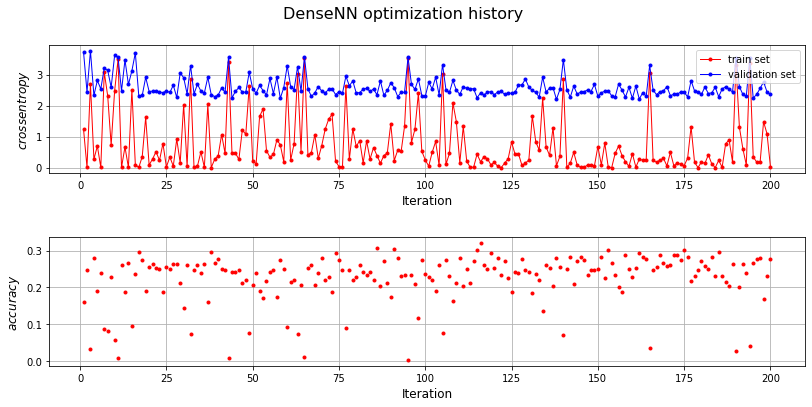

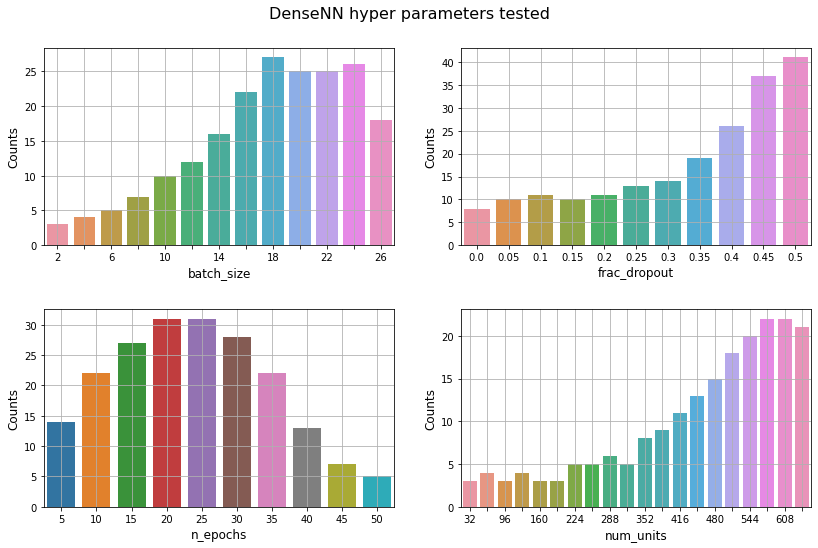

In [32]:
dnn_trials = pkl.load(open('../results/hyperopt/dnn.trials', "rb"))
dnn_space = pkl.load(open('../results/hyperopt/dnn.space', "rb"))
a = plot_hyperopt_analysis(dnn_trials, dnn_space, 'DenseNN')

### 5B. RNN

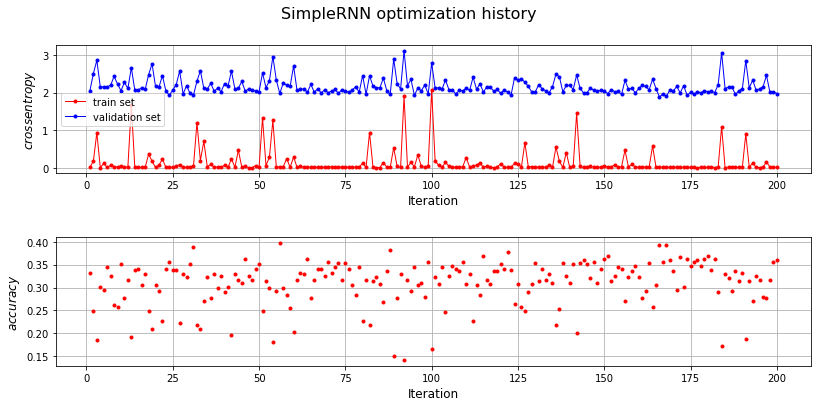

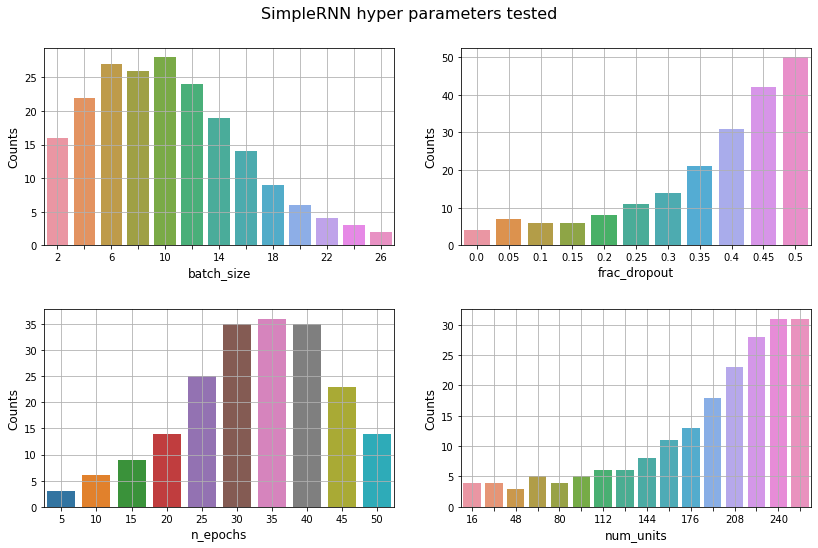

In [33]:
rnn_trials = pkl.load(open('../results/hyperopt/rnn.trials', "rb"))
rnn_space = pkl.load(open('../results/hyperopt/rnn.space', "rb"))
plot_hyperopt_analysis(rnn_trials, rnn_space, 'SimpleRNN')

### 5C. GRU

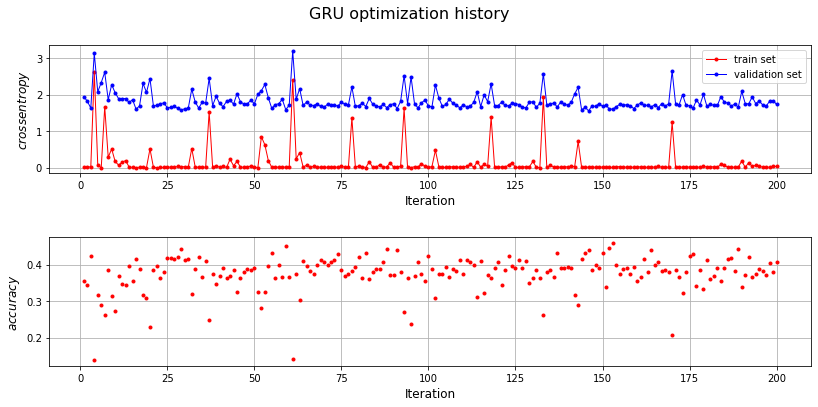

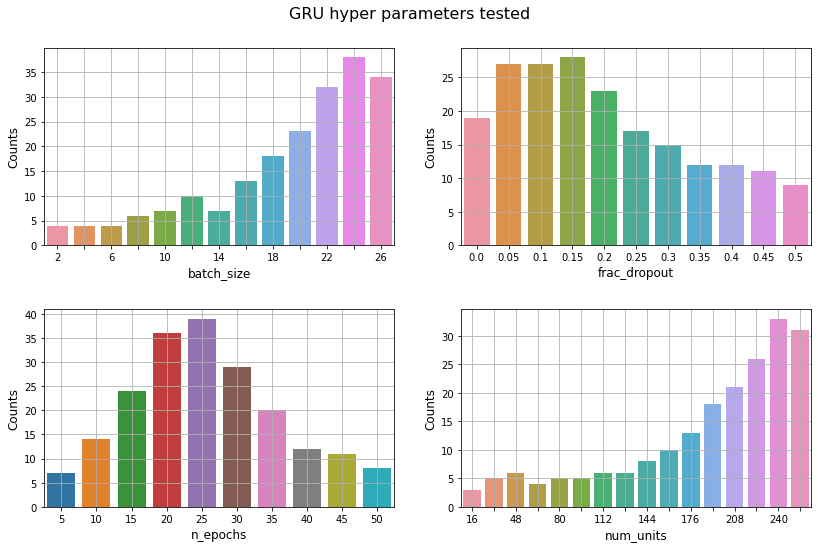

In [9]:
gru_trials = pkl.load(open('../results/hyperopt/gru.trials', "rb"))
gru_space = pkl.load(open('../results/hyperopt/gru.space', "rb"))
plot_hyperopt_analysis(gru_trials, gru_space, 'GRU')

### 5D. LSTM

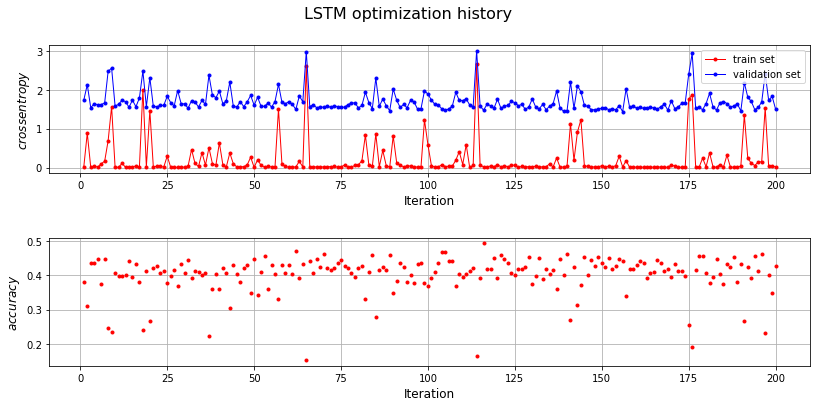

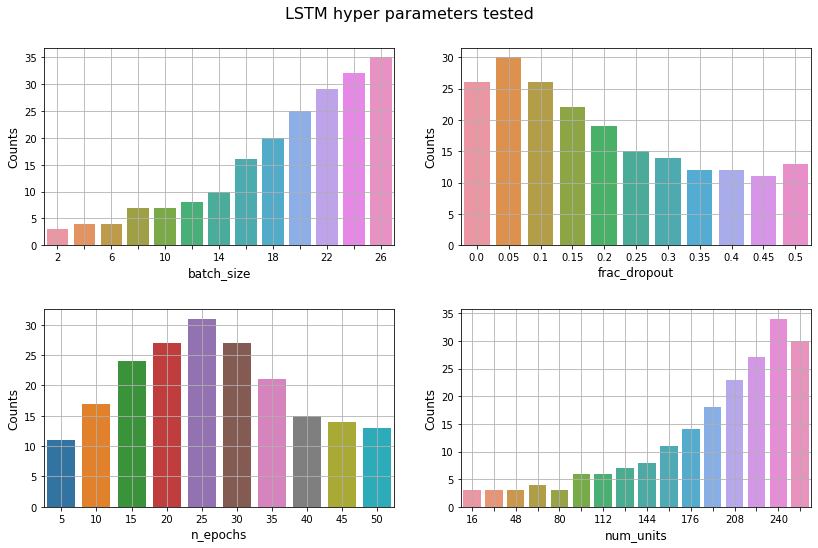

In [35]:
lstm_trials = pkl.load(open('../results/hyperopt/lstm.trials', "rb"))
lstm_space = pkl.load(open('../results/hyperopt/lstm.space', "rb"))
plot_hyperopt_analysis(lstm_trials, lstm_space, 'LSTM')

### 5E. CNN

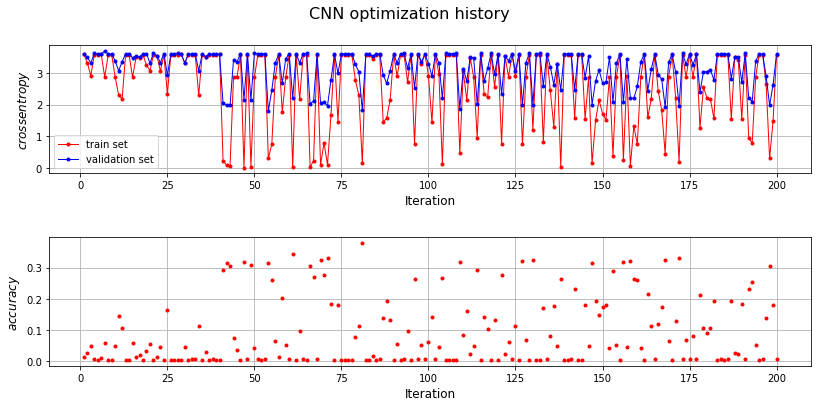

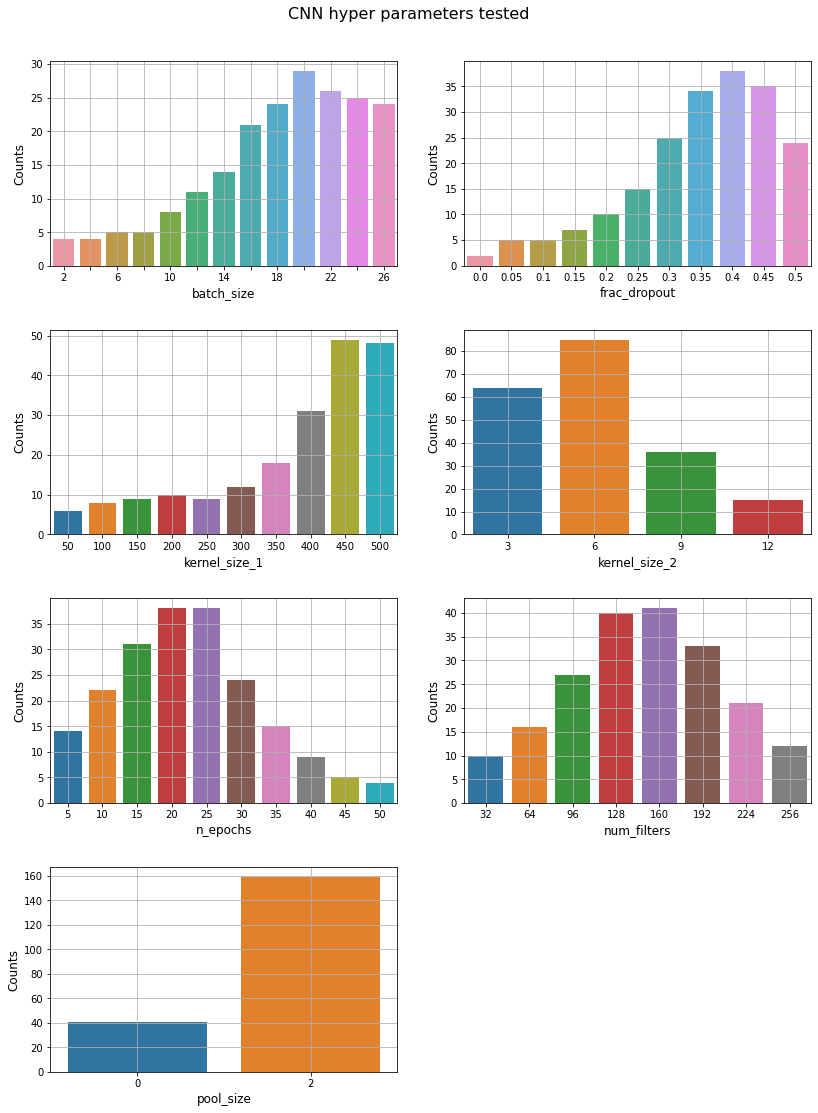

In [15]:
cnn_trials = pkl.load(open('../results/hyperopt/cnn.trials', "rb"))
cnn_space = pkl.load(open('../results/hyperopt/cnn.space', "rb"))
plot_hyperopt_analysis(cnn_trials, cnn_space, 'CNN')

### 5F. ensemble

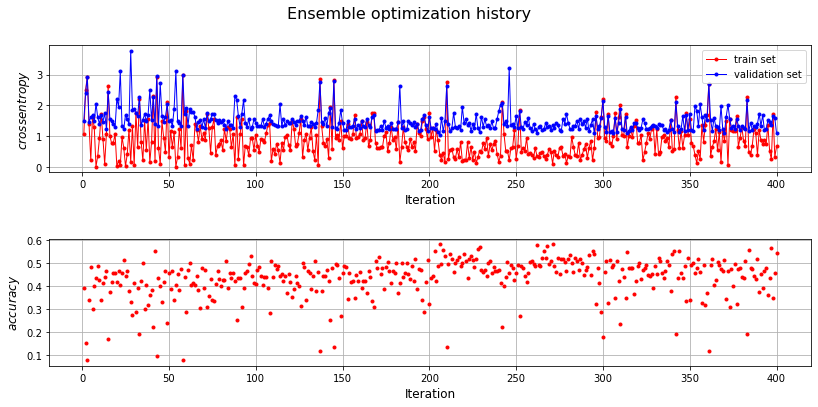

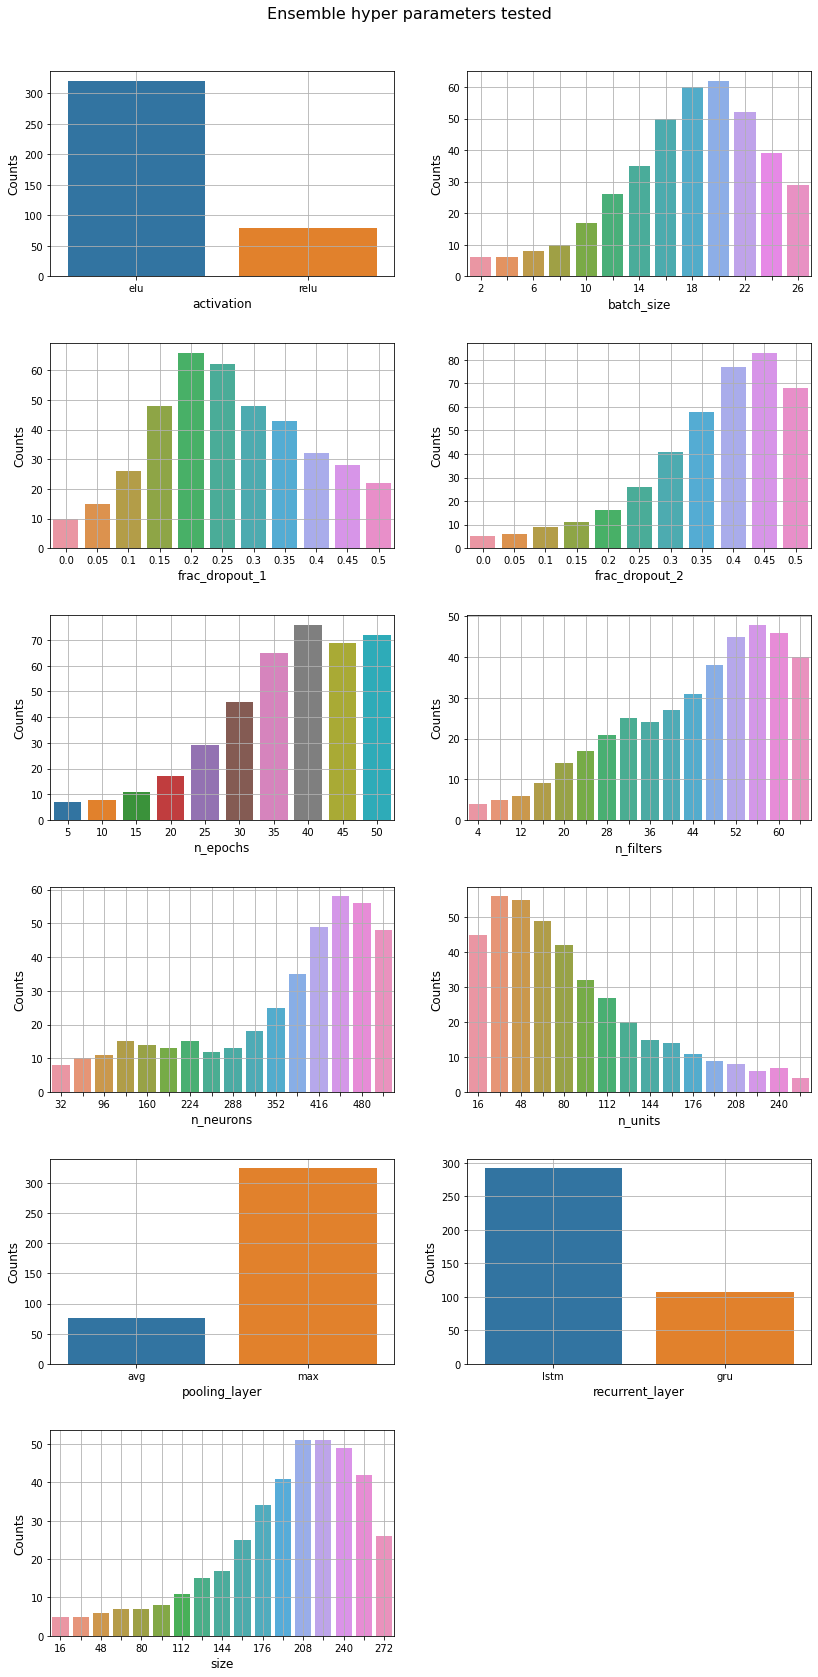

In [38]:
ensemble_trials = pkl.load(open('../results/hyperopt/ensemble.trials', "rb"))
ensemble_space = pkl.load(open('../results/hyperopt/ensemble.space', "rb"))
plot_hyperopt_analysis(ensemble_trials, ensemble_space, 'Ensemble')